# Analyze Data
This Notebook...

todos: Indikatorenvergleich nochmal für Spearman und all durchrechnen
Scatteprlots mit Spearman-Kram
Line-Plots ergänzen
Mertens Tabelle aktualisieren 
Vergleichskapitel weiterschreiben


In [46]:
# import packages

import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from tqdm import tqdm

In [47]:
# read in data file with information about all indicators.
data = pd.read_csv("../data/data.csv", index_col=[0])

In [48]:
# Create dictionaries that store information about the indicator-columns
academic_indicator_dict = {
    'unilist' : [x for x in data.columns if 'prob_to_read_share' in x],
    'litges' : [x for x in data.columns if 'page_count_rel_litges' in x],
    'vv' : [x for x in data.columns if 'event_count_rel_vv' in x],
    'lexica' : ['killy_length'],
    'editions' : ['reclam_count'],
    'bibliographies' : ['BDSL_hits_2000_all']
}

other_indicator_dict = {
    'staatsexamen' : ['staatsexamen_count'],
    'schullist' : [x for x in data.columns if 'schullist_' in x and 'share' in x],
    'abi' : ['abi_mentions'],
    'kanonspiel' : ['kanonspiel_points'],
    'segebrecht' : ['segebrecht_count'],
    'vv_hein' : ['vv_hein_count'],
    'wiki' : ['wiki_length_in_words']
}

all_indicator_dict = {**academic_indicator_dict, **other_indicator_dict}

In [49]:
# Statistics about indictors
print("Number of primary indicators: ", len(all_indicator_dict.keys()))
print("Number of secondary indicators: ", len([element for innerList in list(all_indicator_dict.values()) for element in innerList]))   

print("Number of primary indicators for academic canonicity: ", len(academic_indicator_dict.keys()))
print("Number of secondary indicators for academic canonicity: ", \
      len([element for innerList in list(academic_indicator_dict.values()) for element in innerList]))      

Number of primary indicators:  13
Number of secondary indicators:  69
Number of primary indicators for academic canonicity:  6
Number of secondary indicators for academic canonicity:  50


# GND Filter

In [ ]:
# Define relevant filters

relevant_occupations = [
    'Schriftsteller', 'Schriftstellerin', 'Dramatiker',
    'Lyriker', 'Drehbuchautor', 'Librettist',
    'Autor', 'Lyrikerin', 'Kirchenlieddichter',
    'Erzähler', 'Drehbuchautorin', 'Kinderbuchautor',
    'Dramatikerin', 'Librettistin', 'Liederdichter',
    'Kinderbuchautorin', 'Autorin', 'Jugendbuchautor',
    'Minnesänger', 'Mundartschriftsteller', 'Jugendbuchautorin',
    'Musikschriftsteller', 'Romancier', 'Reiseschriftsteller',
    'Meistersinger', 'Kriminalschriftsteller', 'Liedermacher',
    'Prosaist', 'Kirchenlieddichterin', 'Prosaistin',
    'Theaterdichter', 'Heimatschriftsteller', 'Erzählerin',
    'Spruchdichter', 'Mundartschriftstellerin', 'Romanschriftstellerin',
    'Liederdichterin', 'Musikschriftstellerin',
    'Liedermacherin', 'Bilderbuchautor', 'Stadtschreiberin <Literatur>',
    'Kriminalschriftstellerin', 'Exilschriftsteller', 'Comicautorin',
    'Bestsellerautorin', 'Reiseschriftstellerin',

    'Satiriker', 'Hofdichter', 'Satirikerin',
    'Reisebuchautor',
]

relevant_countries = [
    'Deutschland',
    'Österreich',
    'Schweiz'
]

In [ ]:
print("Number of people in dataset BEFORE gnd filtering : ", data.shape[0])
data = (
    data
    .query("GND_birth >= 1550")
    .loc[data['GND_occupation'].str.contains('|'.join(relevant_occupations), na=False)]
    .loc[data['GND_country'].str.contains('|'.join(relevant_countries), na=False)]
).copy()

print("Number of people in dataset AFTER  gnd filtering : ", data.shape[0])

Number of people in dataset BEFORE gnd filtering :  9628
Number of people in dataset AFTER  gnd filtering :  5310


# Manual Filter

In [52]:
entities_to_delete = [
    '118509039', # Benjamin, Walter
    '118594117', # Wagner, Richard
    '118500775', # Adorno, Theodor W.
    '118603426', # Rousseau, Jean-Jacques
    '118554727', # Humboldt, Wilhelm von
    '11862220X', # Thomasius, Christian
    '118607057', # Schelling, Friedrich Wilhelm Joseph von
    '118532847', # Fichte, Johann Gottlieb
    '118554700', # Humboldt, Alexander von
    '11850391X', # Arendt, Hannah
    '118638289', # Čechov, Anton Pavlovič
    '118627813', # Voltaire
    '118664123', # Blumenberg, Hans
    '118535749', # Friedrich II., Preußen, König
    '11574326X', # Arnold, Heinz Ludwig
    '118608045', # Schleiermacher, Friedrich
    '118525727', # Dilthey, Wilhelm
    '118599194', # Reich-Ranicki, Marcel
    '118584790', # Müller, Adam Heinrich
    '118556312', # Jacobi, Friedrich Heinrich
    '120309297', # Detering, Heinrich
    '118514881', # Breitinger, Johann Jakob
    '119090198', # Wagenseil, Johann Christoph
    '119505258', # Sepúlveda, Luis
    '118795163', # Schlosser, Johann Georg
    '118891871', # Skármeta, Antonio
    '121846067', # Illies, Florian
    '118630040', # Weidig, Friedrich Ludwig
    '118557327', # Jens, Walter
    '118631764', # Wessenberg, Ignaz Heinrich von
    '118516477', # Buber, Martin
    '11874559X', # Rochow, Friedrich Eberhard von
    '118628836', # Wallraff, Günter
    '118763784', # Unseld, Siegfried

    '118501259', # Ajtmatov, Čingiz
    '118513532', # Borges, Jorge Luis
    '118518208', # Byron, George Gordon Byron, Baron
    '118518739', # Camus, Albert
    '118519948', # Césaire, Aimé'
    '118541765', # Green, Julien
    '118555707', # Ionesco, Eugène
    '118765396', # Sillitoe, Alan
 ]

In [53]:
# Filter Entities from dataframe
print("Number of people in dataset BEFORE manual filtering : ", data.shape[0])
data = data[~data["GND"].isin(entities_to_delete)]

print("Number of people in dataset AFTER  manual filtering : ", data.shape[0])

Number of people in dataset BEFORE manual filtering :  5310
Number of people in dataset AFTER  manual filtering :  5268


# Normalize and Create scores, etc.

In [54]:
def add_scores(df, all_indicator_dict = all_indicator_dict, canon_indicator_dict = academic_indicator_dict, method_first_merge = 'median', method_second_merge = 'median'):
    # (1) apply zscore and rank on secondary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        for secondary_indicator in secondary_indicators:
            df[secondary_indicator+'_zscore'] = zscore(df[secondary_indicator])
            df[secondary_indicator+'_rank'] = df[secondary_indicator].rank(method='min', ascending=False).astype(int)
        df = df.copy()

    # (2) create score for primary indicators by calculating mean or median of zscored secondary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        if method_first_merge == 'mean':
            df[primary_indicator] = df[[x+'_zscore' for x in secondary_indicators]].mean(axis=1)
        elif method_first_merge == 'median':
            df[primary_indicator] = df[[x+'_zscore' for x in secondary_indicators]].median(axis=1)
        else:
            print("wrong method_first_merge")
    df = df.copy()

    # (3) apply zscore and rank on primary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        df[primary_indicator+'_zscore'] = zscore(df[primary_indicator])
        df[primary_indicator+'_rank'] = df[primary_indicator].rank(method='min', ascending=False).astype(int)
    df = df.copy()

    # (4) create overall canonicity score by calculating mean or median of zscored primary indicators
    if method_second_merge == 'mean':
        df['canonicity_score_raw'] = df[[x+'_zscore' for x in canon_indicator_dict.keys()]].mean(axis=1)
    elif method_second_merge == 'median':
        df['canonicity_score_raw'] = df[[x+'_zscore' for x in canon_indicator_dict.keys()]].median(axis=1)
    else:
        print("wrong method_second_merge")

    # (5) apply rank and scaling on overall canonictiy score
    scaler = MinMaxScaler(feature_range=(1, 1000))
    df['canonicity_score_rank'] = df['canonicity_score_raw'].rank(method='min', ascending=False).astype(int)
    df['canonicity_score_scaled'] = scaler.fit_transform(df[['canonicity_score_raw']]).round().astype(int)

    return df

In [55]:
data = add_scores(data)

# Explore Authors with highest ranks

In [56]:
data.sort_values(by='canonicity_score_raw', ascending=False)[[
    'GND', 'GND_name',
    'canonicity_score_rank', 'canonicity_score_scaled', 'canonicity_score_raw',
]].reset_index(drop=True).head(20)

GND                     GND_name  canonicity_score_rank  \
0   118540238  Goethe, Johann Wolfgang von                      1   
1   118607626          Schiller, Friedrich                      2   
2   118563076         Kleist, Heinrich von                      3   
3   118514768              Brecht, Bertolt                      4   
4   118577166                 Mann, Thomas                      5   
5   118572121    Lessing, Gotthold Ephraim                      6   
6   118559230                 Kafka, Franz                      7   
7   118552465           Hoffmann, E. T. A.                      8   
8   118548018              Heine, Heinrich                      9   
9   118552759       Hofmannsthal, Hugo von                     10   
10  118534262             Fontane, Theodor                     11   
11  118551981         Hölderlin, Friedrich                     12   
12  118601024          Rilke, Rainer Maria                     13   
13  118541579                Grass, Günter                     14   
14  118516906               Büchner, Georg                     15   
15  118618156            Stifter, Adalbert                     16   
16  118546937           Hauptmann, Gerhart                     17   
17  118545574                Handke, Peter                     18   
18  12989432X                Tieck, Ludwig                     19   
19  118529390      Eichendorff, Joseph von                     20   

    canonicity_score_scaled  canonicity_score_raw  
0                      1000             34.835454  
1                       549             19.036228  
2                       435             15.039432  
3                       427             14.770936  
4                       335             11.563215  
5                       316             10.885844  
6                       315             10.849147  
7                       302             10.392757  
8                       277              9.529944  
9                       227              7.756006  
10                      224              7.658455  
11                      210              7.164837  
12                      188              6.386794  
13                      186              6.331268  
14                      183              6.230113  
15                      177              6.008447  
16                      167              5.676823  
17                      165              5.588256  
18                      163              5.544291  
19                      154              5.202691

# Visualize Top 100 (per Indicator)

In [44]:
def visualize_top_colored_by_gender(data, column, n_top=20, show=True):
    gender_mapping = {"Weiblich": "maroon", "Männlich": "peru"}
    
    data_small = data.sort_values(by=column, ascending=False)
    data_small = data_small.reset_index(drop=True).loc[0:n_top] 
    fig = px.bar(data_small, x="GND_name", y=column, color="GND_gender", color_discrete_map=gender_mapping)
    
    
    fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=10)})

    # path = f"../figures/Top_x_gender_coloured/Top_{n_top}_gender_coloured_{column}.png"
    # fig.write_image(path, width=2000, height=1000, scale=3)
    
    if show==True:
        fig.update_layout(xaxis={"tickfont" : dict(size=7)})
        fig.show()

In [45]:
visualize_top_colored_by_gender(data, "wiki_zscore", n_top=100, show=True)

In [ ]:
for primary_indicator, secondary_indicators in all_indicator_dict.items():
    visualize_top_colored_by_gender(data, primary_indicator+'_zscore', n_top=50, show=False)

In [ ]:
def visualize_top(data, column, n_top=20, show=True):
    
    data_small = data.sort_values(by=column, ascending=False)
    data_small = data_small.reset_index(drop=True).loc[0:n_top] 
    fig = px.bar(data_small, x="GND_name", y=column,
                 color_discrete_sequence=["black"],
                 #hover_data=["canonicity_score_scaled", "canonicity_score_rank"],\
                template='seaborn', text_auto='')
    
    fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=7)},\
                     yaxis_title="Kanonizität")

    path = f"../figures/Top_x/Top_{n_top}_{column}.png"
    fig.write_image(path, width=2000, height=1000, scale=3)
    if show==True:
        fig.show()
    


In [ ]:
visualize_top(data, "canonicity_score_scaled", n_top=50)

# Number of Authors per Indicator

In [ ]:
# Compute Number of Authors per sec. Indicator
result = pd.DataFrame([
    {
        "Primary_Indicator": prim_indicator,
        "Secondary_Indicator": sec_indicator,
        "Num_Authors": (data[sec_indicator] != 0.0).sum()
    }
    for prim_indicator, sec_indicators in all_indicator_dict.items()
    for sec_indicator in sec_indicators
])

result["Num_Authors_rel"] = result["Num_Authors"] / len(data)

# Visualize Number of Authors per secondary Indicator

fig = px.bar(result, x="Secondary_Indicator", y="Num_Authors")#, color="Secondary_Indicator", barmode="group")
fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=8)})

path = f"../figures/num_authors_per_indicator/num_authors_per_sec_indicator.png"
fig.write_image(path, width=2000, height=1000, scale=3)
fig.show()

In [ ]:
# Number of Authors per prim. Indicator

result = pd.DataFrame([
    {
        "Primary_Indicator": prim,
        "Number_Authors": (data[secs] != 0).any(axis=1).sum()
    }
    for prim, secs in all_indicator_dict.items()
])

# Visualize Number of Authors per prim. Indicator

fig = px.bar(result, x="Primary_Indicator", y="Number_Authors")#, color="Secondary_Indicator", barmode="group")
fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=15)})

path = f"../figures/num_authors_per_indicator/num_authors_per_prim_indicator.png"
fig.write_image(path, width=2000, height=1000, scale=3)
fig.show()

# Explore filtered authors

In [ ]:
data_unfiltered = pd.read_csv("../data/data.csv", index_col=[0])
data_unfiltered = add_scores(data_unfiltered)

In [ ]:
gnd_ids_filtered = data['GND'].tolist()
data_lost = data_unfiltered.query("GND not in @gnd_ids_filtered")
data_lost.sort_values(by='canonicity_score_rank', ascending=True)[[
    'GND_name', 'GND_birth', 'GND_death', 'GND_country', 'GND_occupation',
      'canonicity_score_rank'
]]

GND_name  GND_birth  GND_death  \
2995       Benjamin, Walter     1892.0     1940.0   
4557   Shakespeare, William     1564.0     1616.0   
4020         Luther, Martin     1483.0     1546.0   
2864     Adorno, Theodor W.     1903.0     1969.0   
4267        Wagner, Richard     1813.0     1883.0   
...                     ...        ...        ...   
7980        Erdmann, Nadine        NaN        NaN   
9029        Nicholls, David     1966.0        NaN   
8998  Cottrell Boyce, Frank     1959.0        NaN   
9163          Dowd, Siobhan     1960.0     2007.0   
8621          Küchen, Maria     1961.0        NaN   

                                       GND_country  \
2995            Frankreich + Deutschland + Schweiz   
4557                                Großbritannien   
4020                                   Deutschland   
2864      USA + Deutschland + Österreich + Schweiz   
4267  Österreich + Italien + Deutschland + Schweiz   
...                                            ...   
7980                                   Deutschland   
9029                                Großbritannien   
8998                                Großbritannien   
9163                                Großbritannien   
8621                                      Schweden   

                                         GND_occupation  canonicity_score_rank  
2995  Philosoph + Literaturkritiker + Übersetzer + S...                     17  
4557  Schriftsteller + Dramatiker + Lyriker + Schaus...                     18  
4020  Reformator + Theologe + Komponist + Übersetzer...                     40  
2864  Philosoph + Komponist + Soziologe + Schriftste...                     44  
4267                         Komponist + Schriftsteller                     45  
...                                                 ...                    ...  
7980                        Lehrerin + Schriftstellerin                   9569  
9029      Schriftsteller + Schauspieler + Drehbuchautor                   9569  
8998  Drehbuchautor + Filmschaffender + Kinderbuchautor                   9569  
9163                     Schriftstellerin + Redakteurin                   9569  
8621  Journalistin + Literaturkritikerin + Lyrikerin...                   9569  

[4354 rows x 6 columns]

In [ ]:
# check filtered occupations
#focus_occupation = 'Humorist'#

#data_unfiltered.loc[
#    (data_unfiltered['GND_birth'] >= 1550) & 
#    (~data_unfiltered['GND_occupation'].str.contains('|'.join(relevant_occupations), na=False)) & 
#    (data_unfiltered['GND_occupation'].str.contains(focus_occupation, na=False))
#    .loc[data_unfiltered['GND_country'].str.contains('|'.join(relevant_countries), na=False)]
#][['GND', 'GND_name', 'GND_birth', 'GND_death', 'GND_occupation']].values

# Vergleich Wiki-Metriken

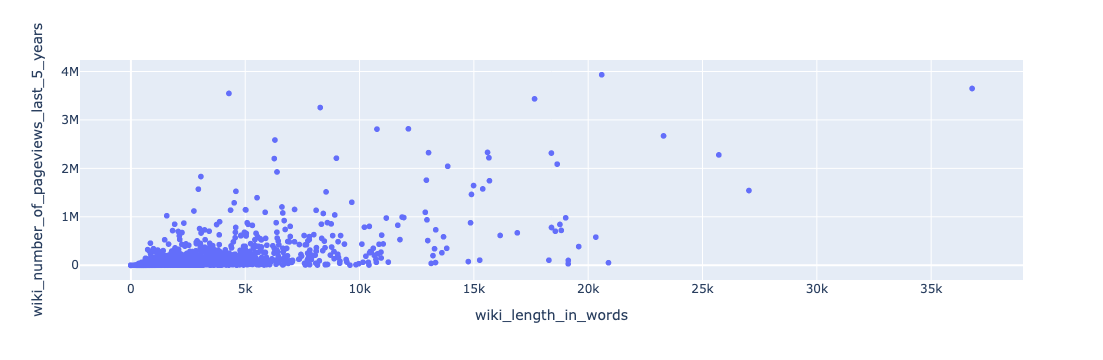

In [ ]:
data[[
    'wiki_length_in_words',
    'wiki_number_of_sitelinks',
    'wiki_number_of_pageviews_last_5_years',
    'wiki_number_of_in_links'
]].corr(method='spearman')

px.scatter(
    data,
    x = 'wiki_length_in_words',
    y = 'wiki_number_of_pageviews_last_5_years',
    hover_name='GND_name',
    hover_data = ['wiki_page_url']
)

# Heatmaps with Correlations

In [ ]:
def visualize_heatmap(method, n_top=100, show=True):

    corr_results = (
    data
    .query(f"canonicity_score_rank <= {n_top}")
    [[x+'_zscore' for x in all_indicator_dict.keys()]]
    .apply(zscore)
    .corr(method=method)
    )
    
    plt.figure(figsize=(12, 10))
    
    sns.heatmap(
        corr_results,
        annot=True,
        cmap="RdBu_r",   # oder "coolwarm"
        center=0,        # 0 wird mittig weiß
        vmin=-1, vmax=1  # gesamte Range -1 bis +1 abbilden
    )
    
    plt.tight_layout()
    plt.savefig(f"../figures/heatmaps/heatmap_Top_{n_top}_{method}.png", dpi=300)
    if show==True:
        plt.show()
    plt.close()
    

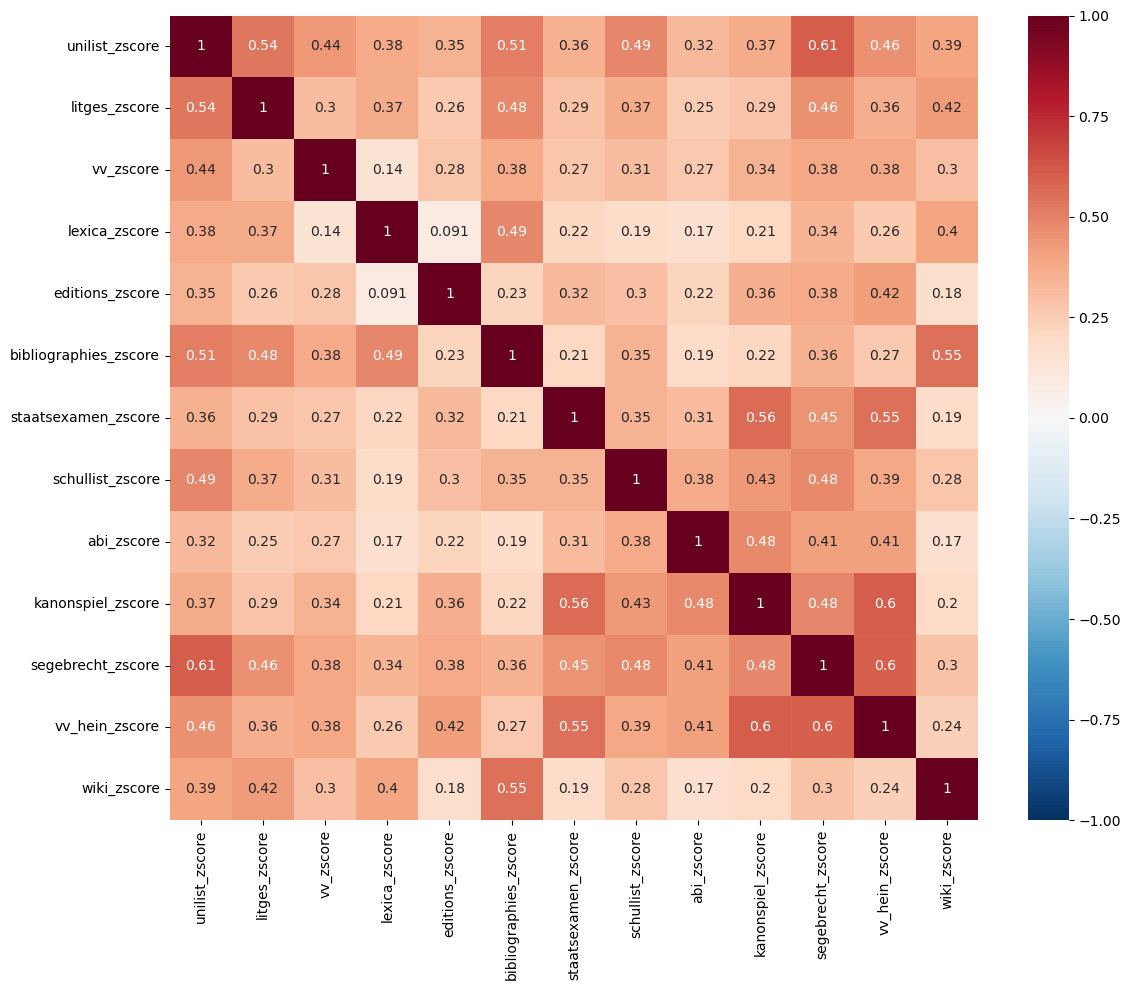

In [ ]:
visualize_heatmap("spearman", n_top=10000, show=True)

In [ ]:
def visualize_half_heatmap(method, n_top=10000, show=True):

    corr_results = (
    data
    .query(f"canonicity_score_rank <= {n_top}")
    [[x+'_zscore' for x in all_indicator_dict.keys()]]
    .apply(zscore)
    .corr(method=method)
    )

    # Maske für obere Dreieckshälfte (ohne Diagonale)
    mask = np.triu(np.ones_like(corr_results, dtype=bool))
    
    plt.figure(figsize=(12, 10))
    
    sns.heatmap(
        corr_results,
        annot=True,
        cmap="RdBu_r",   # oder "coolwarm"
        center=0,        # 0 wird mittig weiß
        vmin=-1, vmax=1,  # gesamte Range -1 bis +1 abbilden
        mask=mask
    )
    
    plt.tight_layout()
    
    plt.savefig(f"../figures/heatmaps/half_heatmap_Top_{n_top}_{method}.png", dpi=300)
    
    if show==True:
        plt.show()
    plt.close()
    
visualize_half_heatmap("spearman", show=False)

# Korrelationen nach n_top

In [ ]:
mean_corr = {}
for i in tqdm(range(1,len(data))):

    corr_results = (
        data
        .query(f"canonicity_score_rank <= {i}")
        [[x+'_zscore' for x in academic_indicator_dict.keys()]]
        .apply(zscore)
        .corr(method='spearman')
    )
    
    # Durchschnitt aller Off-Diagonal-Werte
    corr_results_ohne_diagonale = corr_results.where(~np.eye(len(academic_indicator_dict.keys()), dtype=bool))#.mean().mean()
    mean_corr[i] = corr_results_ohne_diagonale.mean().mean()

100%|████████████████████████████████████| 5273/5273 [00:42<00:00, 122.82it/s]


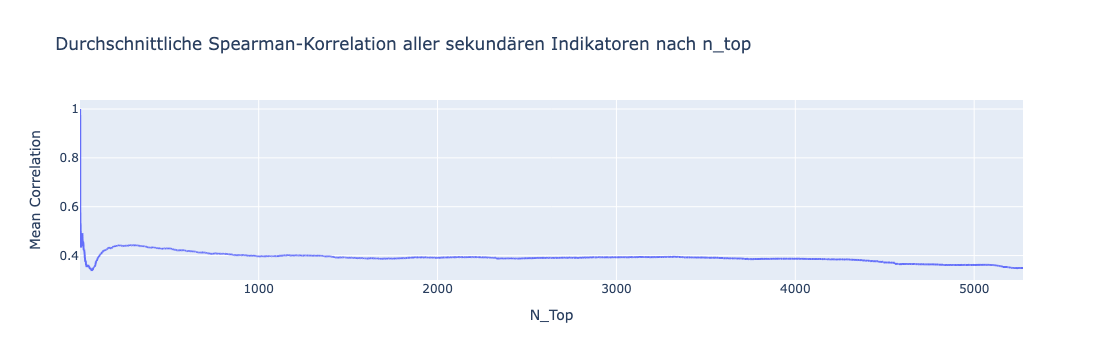

In [ ]:
result = pd.DataFrame({"N_Top": mean_corr.keys(), "Mean Correlation": mean_corr.values()})
fig = px.line(result, x="N_Top", y="Mean Correlation", title="Durchschnittliche Spearman-Korrelation aller sekundären Indikatoren nach n_top")

path = f"../figures/line_plots/spearman.png"
fig.write_image(path, width=2000, height=1000, scale=3)
fig.show()

# Top 5 für unilist, schullist, bibl (als Beispiel)


In [ ]:
unilist_top5 = data[["GND_name", "unilist_zscore"]].sort_values(by="unilist_zscore", ascending=False).reset_index().loc[0:4]
bibl_top5 = data[["GND_name", "bibliographies_zscore"]].sort_values(by="bibliographies_zscore", ascending=False).reset_index().loc[0:4]
schullist_top5 = data[["GND_name", "schullist_zscore"]].sort_values(by="schullist_zscore", ascending=False).reset_index().loc[0:4]
#vv_top5

# Durchschnittliche Korrelationen für vers. Gruppen

# Wie viele Autor:innen sind bei allen in den Top x?

In [ ]:
academic_prim_indicators = list(academic_indicator_dict.keys())

groeße_schnittmenge = {
    n_top: len(
        set.intersection(
            *[
                set(
                    data.sort_values(by=f"{indicator}_zscore", ascending=False)
                        .head(n_top)["GND"]
                )
                for indicator in academic_prim_indicators
            ]
        )
    )
    for n_top in tqdm(range(1, len(data)))
}




100%|█████████████████████████████████████| 5273/5273 [01:43<00:00, 50.97it/s]


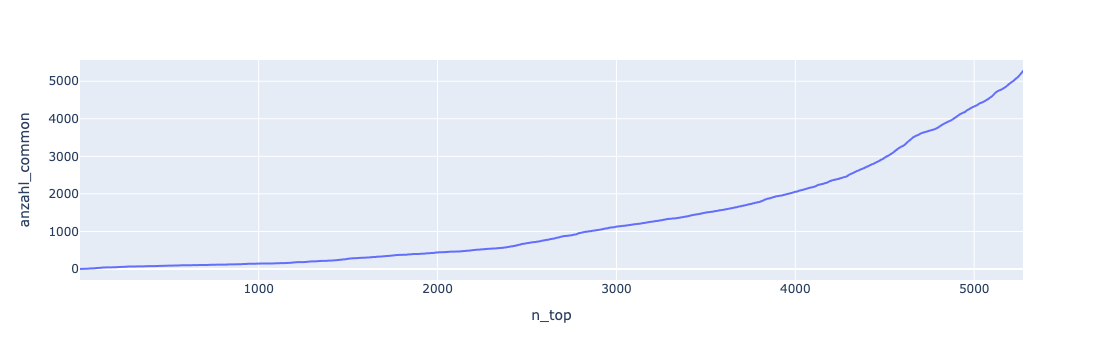

In [ ]:
result = pd.DataFrame({
    "n_top": list(groeße_schnittmenge.keys()),
    "anzahl_common": list(groeße_schnittmenge.values())
})


fig = px.line(result, x="n_top", y="anzahl_common")
path = f"../figures/line_plots/schnittmengen.png"
fig.write_image(path, width=2000, height=1000, scale=3)
fig.show()

# Welche Autor:innen sind bei allen in den Top 100?

In [ ]:
n_top = 100

top_per_indicator = {}
for indicator in academic_prim_indicators:
    column = f"{indicator}_zscore"
    authors = data.sort_values(by=column, ascending=False).reset_index().loc[0:n_top]["GND"].to_list()
    top_per_indicator[indicator] = set(authors)

schnittmenge = top_per_indicator["unilist"]&top_per_indicator["litges"]&top_per_indicator["lexica"]&top_per_indicator["vv"]&\
                top_per_indicator["editions"]&top_per_indicator["bibliographies"]

the_common_x = pd.DataFrame({"GND": list(schnittmenge)})
the_common_x = pd.merge(the_common_x, data[["GND", "GND_name", "canonicity_score_scaled"]], on="GND", how="left")
the_common_x.sort_values(by="canonicity_score_scaled", ascending=False).reset_index(drop=True)

GND                      GND_name  canonicity_score_scaled
0   118540238   Goethe, Johann Wolfgang von                     1000
1   118607626           Schiller, Friedrich                      617
2   118563076          Kleist, Heinrich von                      436
3   118559230                  Kafka, Franz                      399
4   118572121     Lessing, Gotthold Ephraim                      370
5   118552465            Hoffmann, E. T. A.                      343
6   118548018               Heine, Heinrich                      316
7   118534262              Fontane, Theodor                      288
8   118552759        Hofmannsthal, Hugo von                      264
9   118516906                Büchner, Georg                      237
10  118601024           Rilke, Rainer Maria                      235
11  118587943          Nietzsche, Friedrich                      228
12  118551981          Hölderlin, Friedrich                      226
13  118618156             Stifter, Adalbert                      194
14  118546937            Hauptmann, Gerhart                      193
15  118632477     Wieland, Christoph Martin                      189
16  118529390       Eichendorff, Joseph von                      189
17  118585916                 Musil, Robert                      181
18  12989432X                 Tieck, Ludwig                      178
19  118509047               Benn, Gottfried                      175
20  118549553  Herder, Johann Gottfried von                      170
21  118618725                Storm, Theodor                      160
22  118557211                     Jean Paul                      154
23  118588893                       Novalis                      137
24  118584162          Moritz, Karl Philipp                      123
25  118587080               Nestroy, Johann                      115
26  118583107                Mörike, Eduard                      107

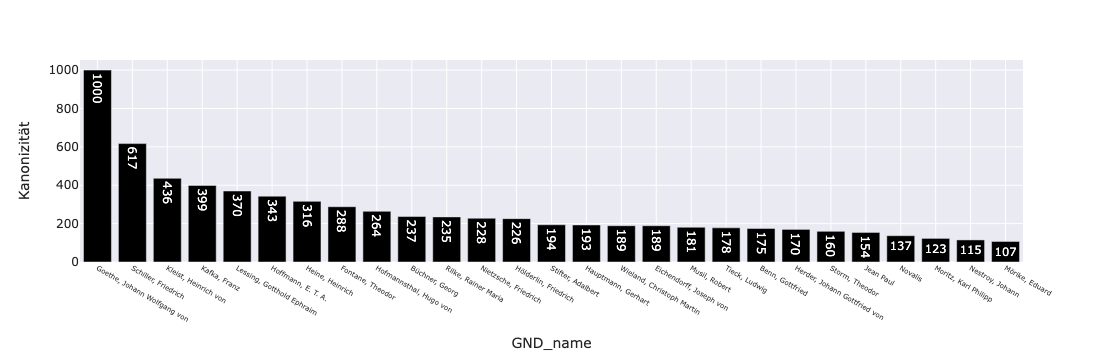

In [ ]:
visualize_top(the_common_x, "canonicity_score_scaled", n_top=27)

# Scatterplots with correlations

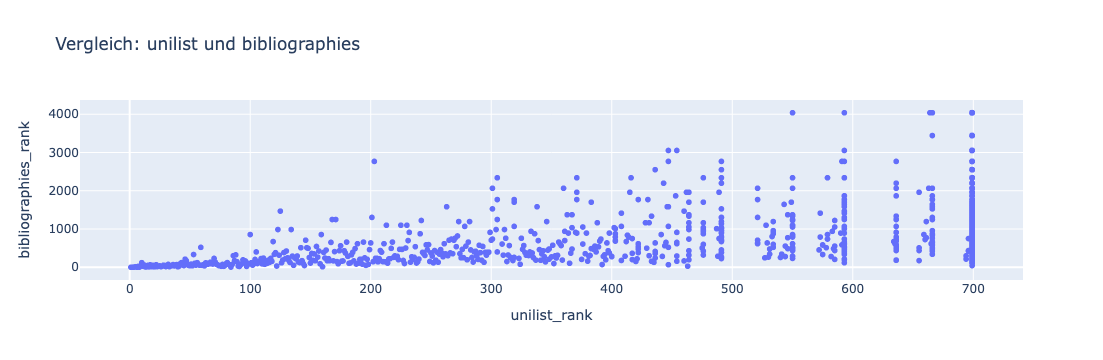

In [ ]:
def visualize_scatterplot(indicator1, indicator2, show=True):
    gender_mapping = {"Weiblich": "maroon", "Männlich": "peru"}

    fig = px.scatter(
        data, 
        x=f"{indicator1}_rank", 
        y=f"{indicator2}_rank", 
         #color="GND_gender", 
         #color_discrete_map=gender_mapping,
        hover_data=["GND_name"],
        title=f"Vergleich: {indicator1} und {indicator2}"
        #trendline="lowess",
        #trendline_color_override="black"
    )
    
    # Abbildung quadratisch machen
   # fig.update_layout(
   #     width=700, 
   #     height=700
   # )
    #fig.update_yaxes(scaleanchor="x", scaleratio=1)
    
    path = f"../figures/scatterplots_rank_correlations/{indicator1}_{indicator2}.png"
    
    fig.write_image(path)
    if show:
        fig.show()

visualize_scatterplot("unilist", "bibliographies")

# PCA

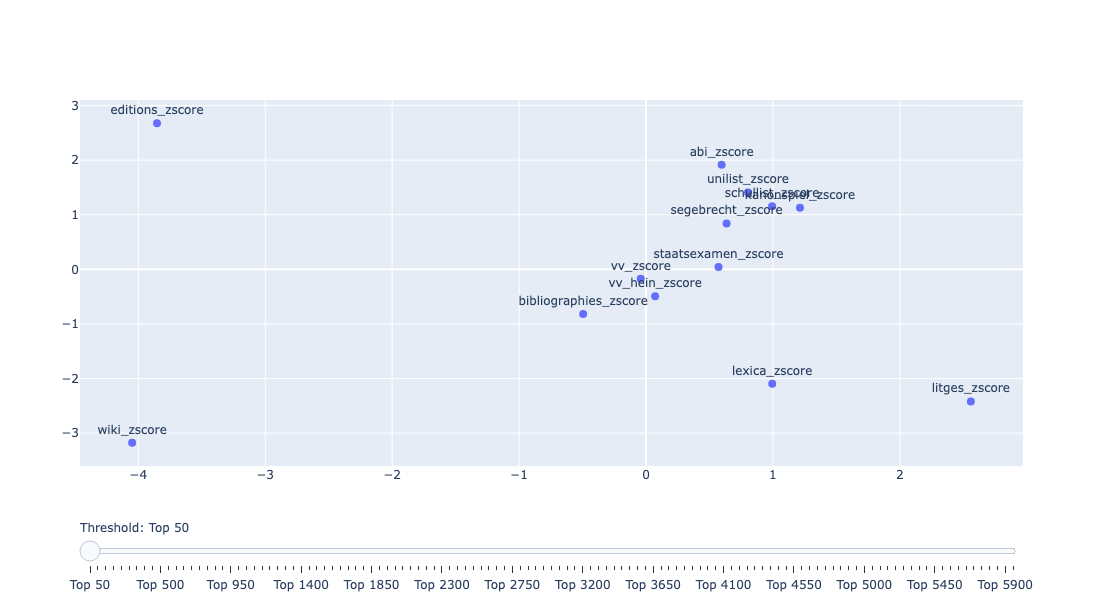

In [ ]:
thresholds = range(50, 6000, 50)

fig = go.Figure()

# add a scatter trace for each threshold
for i, t in enumerate(thresholds):
    filtered = (
        data
        .query(f"canonicity_score_rank <= {t}")
        [[x+'_zscore' for x in all_indicator_dict.keys()]]
        .apply(zscore)
        # .pipe(anonymize)
        .T
    )    
    components = PCA(n_components=2).fit_transform(filtered)
    
    fig.add_trace(go.Scatter(
        x=components[:, 0],
        y=components[:, 1],
        mode='markers+text',
        text=filtered.index,
        textposition='top center',
        marker=dict(size=8),
        name=f'Top {t}',
        visible=(i==0)  # only show the first initially
    ))

# create slider steps: each step makes only one trace visible
steps = []
for i, t in enumerate(thresholds):
    step = dict(
        method='update',
        args=[{'visible': [j == i for j in range(len(thresholds))]}],
        label=f'Top {t}'
    )
    steps.append(step)

# add slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Threshold: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    showlegend=False,
    width=800,
    height=600
)

fig.show()

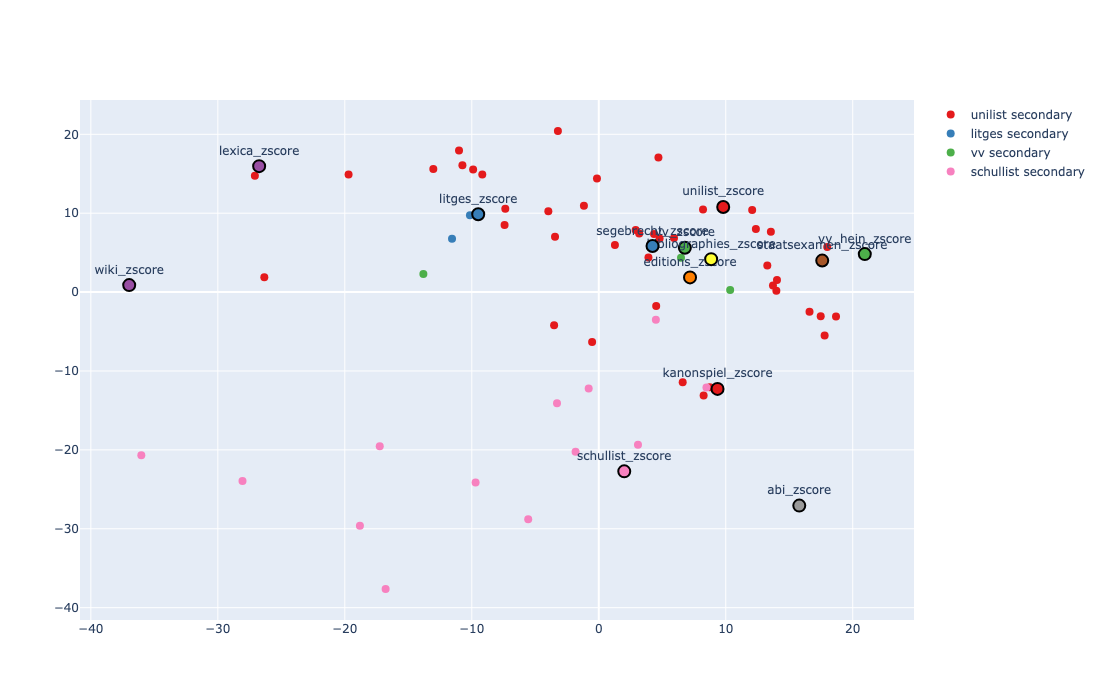

In [ ]:
# Build lists: primary indicators and zscored secondary indicators
primary_indicators = [item+'_zscore' for item in list(all_indicator_dict.keys())]
secondary_indicators = [item+'_zscore' for sublist in all_indicator_dict.values() for item in sublist]

# All columns we need
all_columns = primary_indicators + secondary_indicators

# Filter data (here you can also apply your rank cutoff if you want)
data_compare = data.query("canonicity_score_rank<=999999999")[all_columns]

# Transpose so each column becomes a point in PCA
data_t = data_compare.T

# Run PCA
pca = PCA(n_components=2)
components = pca.fit_transform(data_t)

# Create DataFrame
pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
pca_df['label'] = data_t.index


# Identify group and type
def find_group(label):
    # Remove '_zscore' suffix for matching
    original = label[:-7]  # strip '_zscore'
    
    if original in all_indicator_dict:  # Ensure it's in the dictionary keys (for primary)
        return original  # The primary indicator will return as its own group
    else:
        for group, sublist in all_indicator_dict.items():
            if original in sublist:
                return group
        return 'unknown'

def find_type(label):
    if label in primary_indicators:
        return 'primary'
    else:
        return 'secondary'

pca_df['group'] = pca_df['label'].apply(find_group)
pca_df['type'] = pca_df['label'].apply(find_type)

# Colors: one color per group
group_colors = px.colors.qualitative.Set1
unique_groups = list(all_indicator_dict.keys())
color_map = {group: group_colors[i % len(group_colors)] for i, group in enumerate(unique_groups)}

# Build figure
fig = go.Figure()

# Plot secondary indicators (only if group has more than one secondary), smaller, no outline
for group in unique_groups:
    color = color_map[group]
    subset = pca_df[(pca_df['group'] == group) & (pca_df['type'] == 'secondary')]
    
    if len(subset) > 1:
        fig.add_trace(go.Scatter(
            x=subset['PC1'],
            y=subset['PC2'],
            mode='markers',
            text=subset['label'],
            hoverinfo='text',
            marker=dict(size=8, color=color, line=dict(width=0)),
            name=f'{group} secondary'
        ))

# Plot primary indicators (larger, black ring)
for i, group in enumerate(unique_groups):
    color = color_map[group]
    subset = pca_df[(pca_df['group'] == group) & (pca_df['type'] == 'primary')]
    fig.add_trace(go.Scatter(
        x=subset['PC1'],
        y=subset['PC2'],
        mode='markers+text', # 👈 switch to markers+text to de-anonymize
        text=subset['label'],
        textposition='top center',
        marker=dict(size=12, color=color, line=dict(width=2, color='black')),
        name=f'{group} primary',  # Unique name for the legend
        showlegend=False  # hide primary from legend
    ))

# Update layout to ensure legend and visibility
fig.update_layout(
    width=900,
    height=700,
    showlegend=True  # 👈 switch to True to de-anonymize
)

# Show the plot
fig.show()



# Vermutungen zu Indikatorenvergleich überprüfen

In [ ]:
primary_indicators = list(all_indicator_dict.keys())
secondary_indicators = [item for sublist in all_indicator_dict.values() for item in sublist]
all_indicators = primary_indicators + secondary_indicators

academic_primary_indicators = list(academic_indicator_dict.keys())
nonacademic_primary_indicators = list(other_indicator_dict.keys())
academic_primary_indicators_zscore = [x+'_zscore' for x in academic_primary_indicators]
nonacademic_primary_indicators_zscore = [x+'_zscore' for x in nonacademic_primary_indicators]

In [ ]:
def create_corr_table(data, indicator_type = 'all', top_authors = 9999, method = 'pearson', delete_cross = True):
    data = data.query("canonicity_score_rank <= @top_authors")

    if indicator_type == 'all':
        relevant_columns = [x+'_zscore' for x in all_indicators]
    elif indicator_type == 'primary':
        relevant_columns = [x+'_zscore' for x in primary_indicators]
    elif indicator_type == 'secondary':
        relevant_columns = [x+'_zscore' for x in secondary_indicators]
    data = data[relevant_columns]

    data = data.apply(zscore)

    corr_results = data.corr(method = method)

    if delete_cross:
        mask = ~np.eye(corr_results.shape[0], dtype=bool)
        corr_results = corr_results.where(mask)

    return corr_results

In [ ]:
corr_primary_all_pearson = create_corr_table(data, indicator_type='primary', top_authors=9999, method='pearson')
corr_primary_all_spearman = create_corr_table(data, indicator_type='primary', top_authors=9999, method='spearman')
corr_primary_top50_pearson = create_corr_table(data, indicator_type='primary', top_authors=50, method='pearson')
corr_primary_top50_spearman = create_corr_table(data, indicator_type='primary', top_authors=50, method='spearman')

corr_tables_primary_dict = {
    'primary_all_pearson' : corr_primary_all_pearson,
    'primary_all_spearman' : corr_primary_all_spearman,
    'primary_top50_pearson' : corr_primary_top50_pearson,
    'primary_top50_spearman' : corr_primary_top50_spearman,
}

corr_secondary_all_pearson = create_corr_table(data, indicator_type='secondary', top_authors=9999, method='pearson')
corr_secondary_all_spearman = create_corr_table(data, indicator_type='secondary', top_authors=9999, method='spearman')
corr_secondary_top50_pearson = create_corr_table(data, indicator_type='secondary', top_authors=50, method='pearson')
corr_secondary_top50_spearman = create_corr_table(data, indicator_type='secondary', top_authors=50, method='spearman')

corr_tables_secondary_dict = {
    'secondary_all_pearson' : corr_secondary_all_pearson,
    'secondary_all_spearman' : corr_secondary_all_spearman,
    'secondary_top50_pearson' : corr_secondary_top50_pearson,
    'secondary_top50_spearman' : corr_secondary_top50_spearman,
}

In [ ]:
corr_secondary_all_pearson

prob_to_read_share_unilist_heidelberg_2017_zscore  \
prob_to_read_share_unilist_heidelberg_2017_zscore                                                NaN   
prob_to_read_share_unilist_aachen_201718_zscore                                             0.639188   
prob_to_read_share_unilist_goettingen_zscore                                                0.843497   
prob_to_read_share_unilist_luxemburg_zscore                                                 0.804122   
prob_to_read_share_unilist_graz_2021_zscore                                                 0.644149   
...                                                                                              ...   
abi_mentions_zscore                                                                         0.805835   
kanonspiel_points_zscore                                                                    0.813937   
segebrecht_count_zscore                                                                     0.801678   
vv_hein_count_zscore                                                                        0.838200   
wiki_length_in_words_zscore                                                                 0.359334   

                                                   prob_to_read_share_unilist_aachen_201718_zscore  \
prob_to_read_share_unilist_heidelberg_2017_zscore                                         0.639188   
prob_to_read_share_unilist_aachen_201718_zscore                                                NaN   
prob_to_read_share_unilist_goettingen_zscore                                              0.613852   
prob_to_read_share_unilist_luxemburg_zscore                                               0.597081   
prob_to_read_share_unilist_graz_2021_zscore                                               0.609480   
...                                                                                            ...   
abi_mentions_zscore                                                                       0.547904   
kanonspiel_points_zscore                                                                  0.576180   
segebrecht_count_zscore                                                                   0.631855   
vv_hein_count_zscore                                                                      0.666098   
wiki_length_in_words_zscore                                                               0.331518   

                                                   prob_to_read_share_unilist_goettingen_zscore  \
prob_to_read_share_unilist_heidelberg_2017_zscore                                      0.843497   
prob_to_read_share_unilist_aachen_201718_zscore                                        0.613852   
prob_to_read_share_unilist_goettingen_zscore                                                NaN   
prob_to_read_share_unilist_luxemburg_zscore                                            0.801540   
prob_to_read_share_unilist_graz_2021_zscore                                            0.611699   
...                                                                                         ...   
abi_mentions_zscore                                                                    0.773723   
kanonspiel_points_zscore                                                               0.792027   
segebrecht_count_zscore                                                                0.793642   
vv_hein_count_zscore                                                                   0.830216   
wiki_length_in_words_zscore                                                            0.360495   

                                                   prob_to_read_share_unilist_luxemburg_zscore  \
prob_to_read_share_unilist_heidelberg_2017_zscore                                     0.804122   
prob_to_read_share_unilist_aachen_201718_zscore                                       0.597081   
prob_to_read_share_unilist_goettingen_zscore                                          0.801540

primary_all_pearson


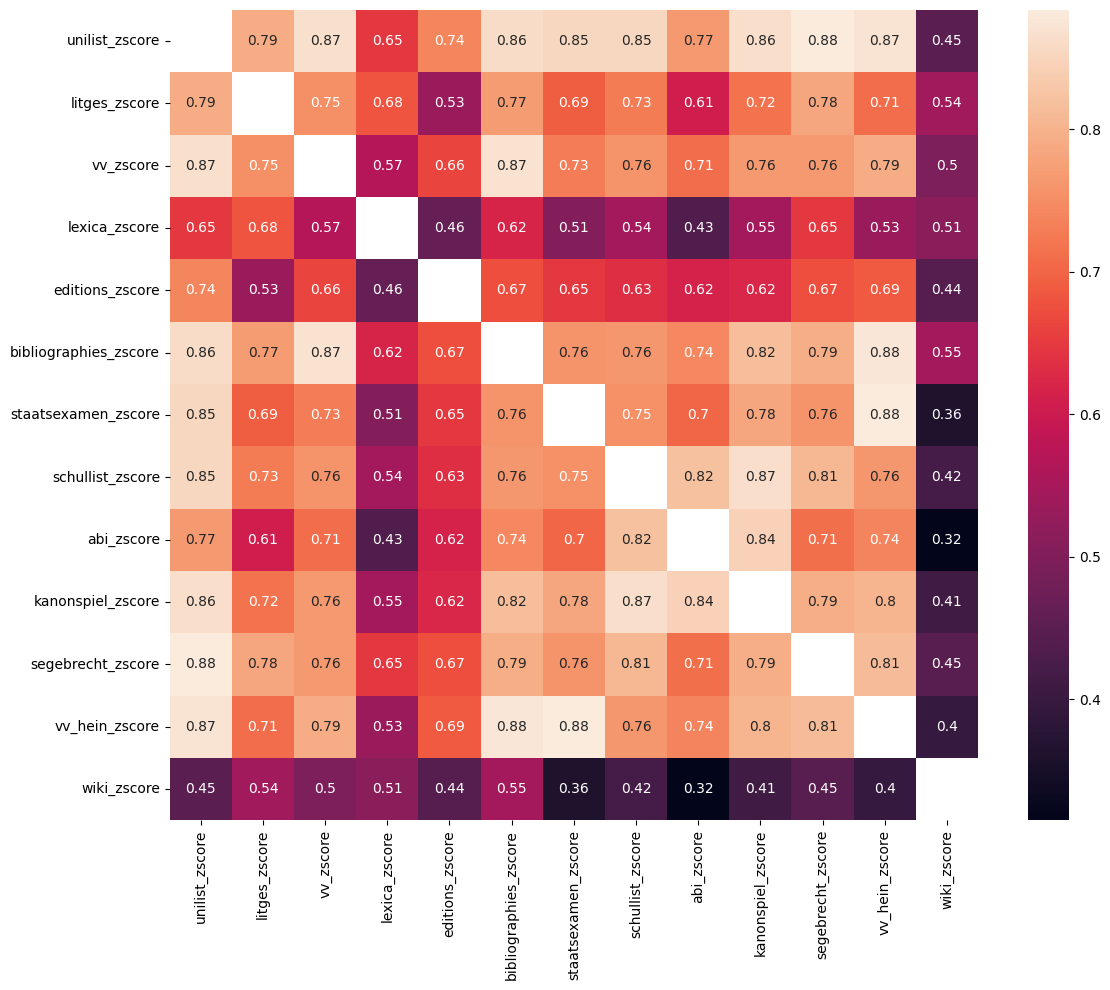

primary_all_spearman


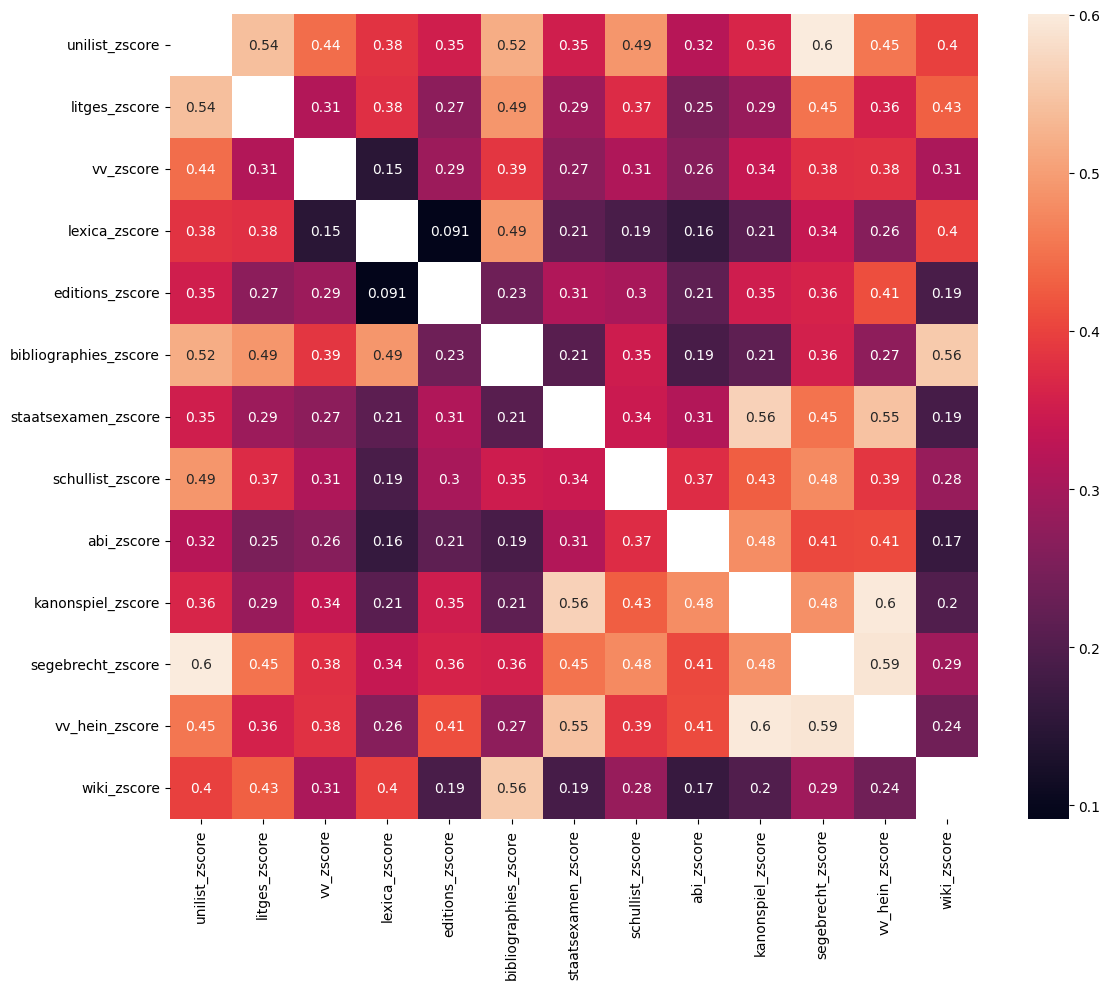

primary_top50_pearson


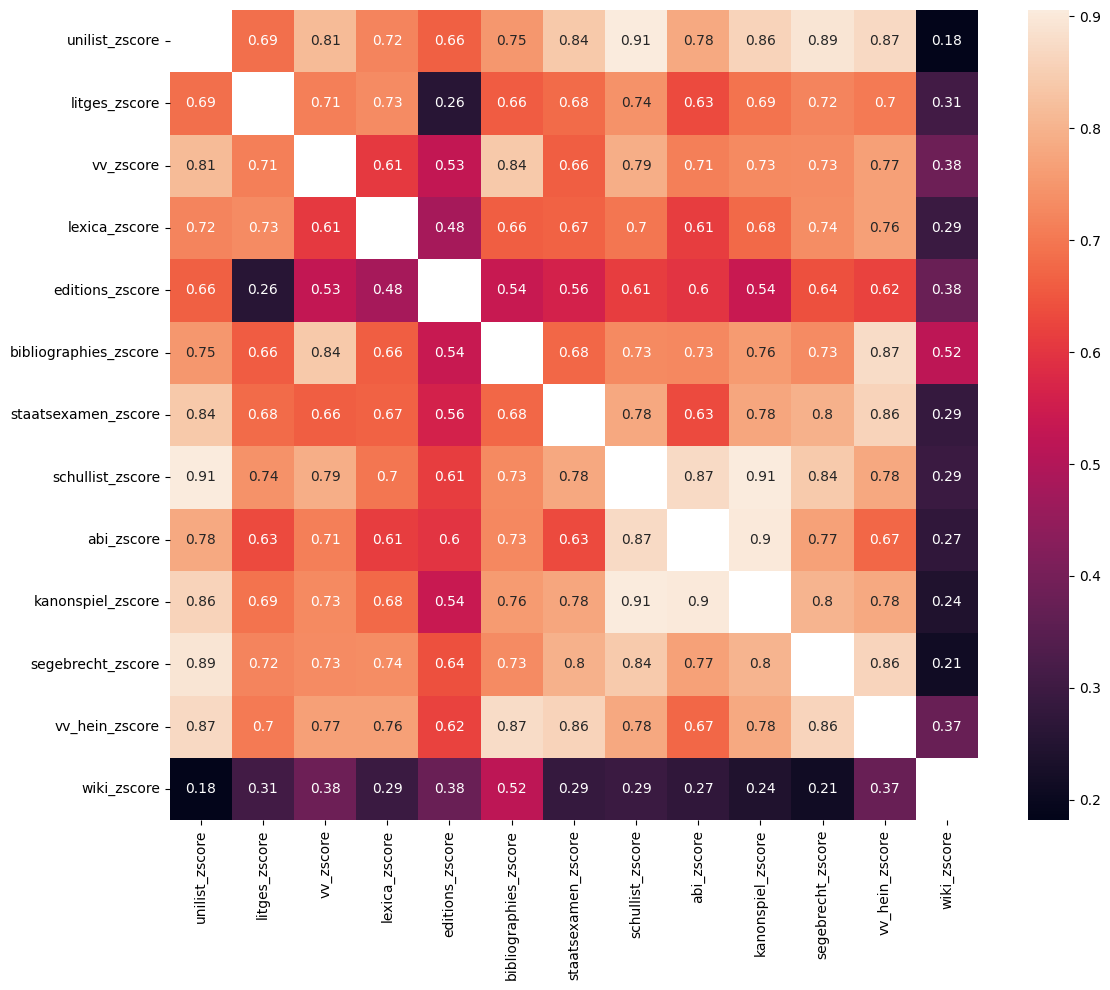

primary_top50_spearman


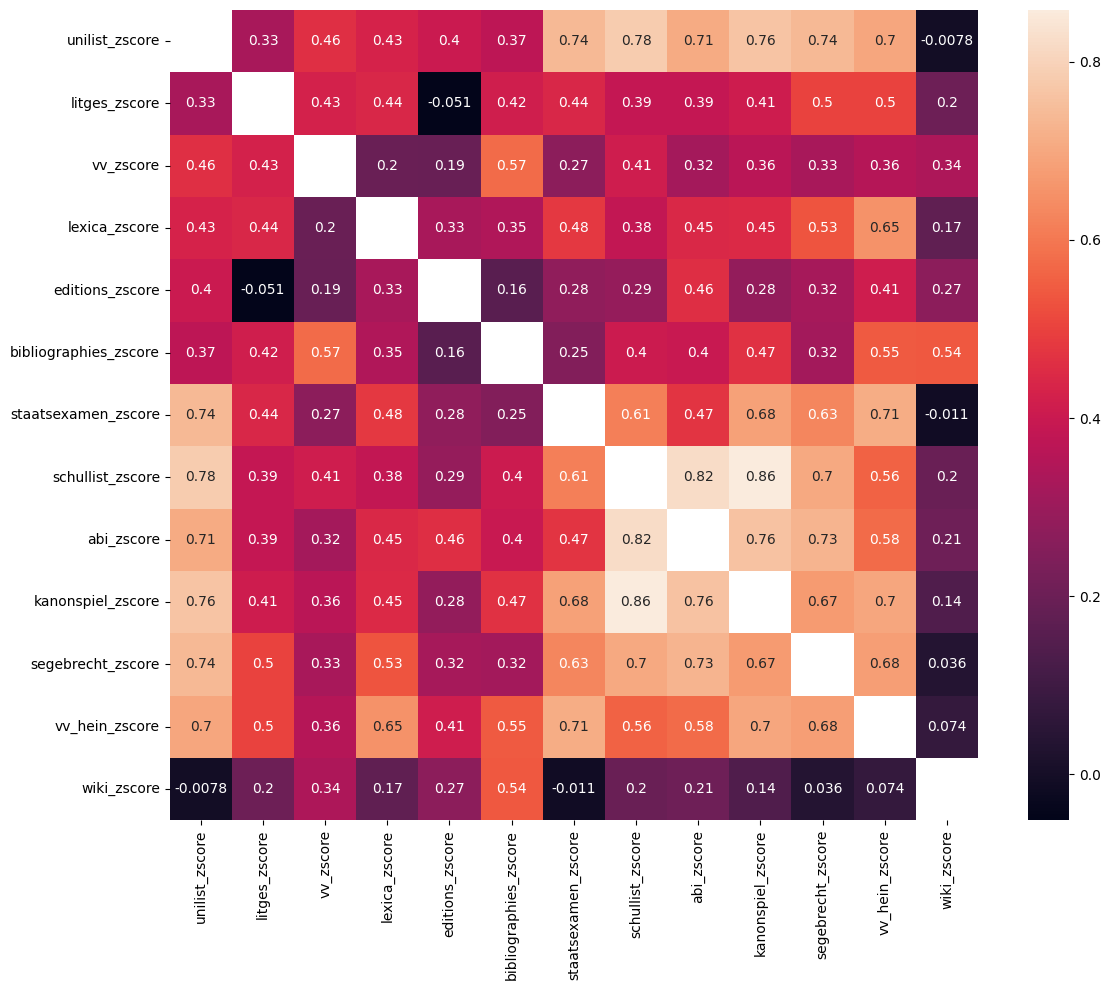

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    print(corr_table_name)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_table, annot=True)
    plt.tight_layout()
    plt.show()

### (1) alle korrelieren positiv miteinander

Operationalisierung: Sind alle Korrelationen zwischen primären Indiaktoren positiv und größer als 0? 

Ergebnis: trifft (fast immmer) zu (einzige Ausnahmen: einige Korrelationen bei primary_top50_spearman)

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    corr_table_unstacked = corr_table.stack().reset_index()
    corr_table_unstacked.columns = ['var1', 'var2', 'value']
    corr_table_unstacked = corr_table_unstacked[corr_table_unstacked['var1'] < corr_table_unstacked['var2']].reset_index(drop=True)

    print(corr_table_name)
    print("5 lowest correlations:")
    print(f"{corr_table_unstacked.sort_values(by='value').head(5).values}")
    print("\n")

primary_all_pearson
5 lowest correlations:
[['abi_zscore' 'wiki_zscore' 0.3152304528381166]
 ['staatsexamen_zscore' 'wiki_zscore' 0.3604599053135926]
 ['vv_hein_zscore' 'wiki_zscore' 0.39625969892654217]
 ['kanonspiel_zscore' 'wiki_zscore' 0.4125227417390518]
 ['schullist_zscore' 'wiki_zscore' 0.41911595944810986]]


primary_all_spearman
5 lowest correlations:
[['editions_zscore' 'lexica_zscore' 0.09121848386844421]
 ['lexica_zscore' 'vv_zscore' 0.1477637457080703]
 ['abi_zscore' 'lexica_zscore' 0.16392161583034084]
 ['abi_zscore' 'wiki_zscore' 0.16619329836907346]
 ['staatsexamen_zscore' 'wiki_zscore' 0.18651022981782256]]


primary_top50_pearson
5 lowest correlations:
[['unilist_zscore' 'wiki_zscore' 0.18168931780785594]
 ['segebrecht_zscore' 'wiki_zscore' 0.21495694730843196]
 ['kanonspiel_zscore' 'wiki_zscore' 0.2413397300446666]
 ['editions_zscore' 'litges_zscore' 0.25933316876012835]
 ['abi_zscore' 'wiki_zscore' 0.27417281791626885]]


primary_top50_spearman
5 lowest correlations

### (2) höhere Korrelationen innerhalb akademisch als mit anderen

Operationalisierung: Ist Durchschnitt der Korrelationen innerhalb primärer akademischer Indikatoren größer als Durchschnitt der Korrelationen zwischen primären akademischen Indikatoren und primären nicht-akademischen Indikatoren?

Ergebnis: nein oder höchstens minimal

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    corr_academic_within = corr_table.loc[academic_primary_indicators_zscore, academic_primary_indicators_zscore].mean().mean()
    corr_other_within = corr_table.loc[nonacademic_primary_indicators_zscore, nonacademic_primary_indicators_zscore].mean().mean()
    corr_academic_other = corr_table.loc[academic_primary_indicators_zscore, nonacademic_primary_indicators_zscore].mean().mean()

    print(corr_table_name)
    print(f"mean corr within academic                  : {corr_academic_within}")
    print(f"mean corr within nonacademic               : {corr_other_within}")
    print(f"mean corr between academic and nonacademic : {corr_academic_other}")
    print("\n")

primary_all_pearson
mean corr within academic                  : 0.6999464027354767
mean corr within nonacademic               : 0.6754670337838268
mean corr between academic and nonacademic : 0.6825921712439581


primary_all_spearman
mean corr within academic                  : 0.3554283370895419
mean corr within nonacademic               : 0.39137731281497323
mean corr between academic and nonacademic : 0.3270229323110413


primary_top50_pearson
mean corr within academic                  : 0.6433507179995918
mean corr within nonacademic               : 0.6533482516991995
mean corr between academic and nonacademic : 0.6668829285936985


primary_top50_spearman
mean corr within academic                  : 0.33457776885643553
mean corr within nonacademic               : 0.5140704809390634
mean corr between academic and nonacademic : 0.4279226942152202




### (3) wiki unähnlicher zu anderen Indikatoren

Operationalisierung: Ist Durchschnitt der Korrelationen zwischen wiki und allen anderen primären Indikatoren kleiner als der Durchschnitt der Korrelationen zwischen allen primären Indikatoren?

Ergebnis: ja

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    all_mean = corr_table.mean().mean()

    results = pd.DataFrame()
    for primary_indicator in primary_indicators:
        results.at[primary_indicator, 'mean_corr'] = corr_table[primary_indicator+'_zscore'].mean().mean()
    results['mean_corr_rank'] = results['mean_corr'].rank(method='min', ascending=False).astype(int)

    print(corr_table_name)
    print(f"mean corr all       : {all_mean}")
    print(f"mean corr wiki      : {results.at['wiki', 'mean_corr']}")
    print(f"mean corr wiki rank : {results.at['wiki', 'mean_corr_rank']}")
    print("\n")

primary_all_pearson
mean corr all       : 0.6840112172145995
mean corr wiki      : 0.4449323427345586
mean corr wiki rank : 13


primary_all_spearman
mean corr all       : 0.3498116895195039
mean corr wiki      : 0.30386011353515013
mean corr wiki rank : 10


primary_top50_pearson
mean corr all       : 0.6587135520078514
mean corr wiki      : 0.312480820862443
mean corr wiki rank : 13


primary_top50_spearman
mean corr all       : 0.4331653819180271
mean corr wiki      : 0.17955644102722965
mean corr wiki rank : 13




### (4) vv_hein unähnlicher zu den anderen

Operationalisierung: Ist Durchschnitt der Korrelationen zwischen vv_hein und allen anderen primären Indikatoren kleiner als der Durchschnitt der Korrelationen zwischen allen primären Indikatoren?

Ergebnis: nein

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    all_mean = corr_table.mean().mean()

    results = pd.DataFrame()
    for primary_indicator in primary_indicators:
        results.at[primary_indicator, 'mean_corr'] = corr_table[primary_indicator+'_zscore'].mean().mean()
    results['mean_corr_rank'] = results['mean_corr'].rank(method='min', ascending=False).astype(int)

    print(corr_table_name)
    print(f"mean corr all          : {all_mean}")
    print(f"mean corr vv_hein      : {results.at['vv_hein', 'mean_corr']}")
    print(f"mean corr vv_hein rank : {results.at['vv_hein', 'mean_corr_rank']}")
    print("\n")

primary_all_pearson
mean corr all          : 0.6840112172145995
mean corr vv_hein      : 0.7387032124366216
mean corr vv_hein rank : 4


primary_all_spearman
mean corr all          : 0.3498116895195039
mean corr vv_hein      : 0.4092102683896392
mean corr vv_hein rank : 3


primary_top50_pearson
mean corr all          : 0.6587135520078514
mean corr vv_hein      : 0.744310927305304
mean corr vv_hein rank : 3


primary_top50_spearman
mean corr all          : 0.4331653819180271
mean corr vv_hein      : 0.5379518638215072
mean corr vv_hein rank : 2




### (5) Bereich Schule untereinander ähnlich, Bereich akademisch untereinander ähnlich

'Bereich akademisch untereinander ähnlich' schon durch (2) geprüft, also Fokus auf 'Bereich Schule untereinander ähnlich'

Operationalisierung: Ist die Korrelation zwischen abi und schullist größer als der Durchschnitt der Korrelationen zwischen allen primären Indikatoren?

Ergebnis: ja

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    all_mean = corr_table.mean().mean()
    corr_abi_schullist = corr_table.loc['abi_zscore', 'schullist_zscore']

    print(corr_table_name)
    print(f"mean corr all       : {all_mean}")
    print(f"corr abi<>schullist : {corr_abi_schullist}")
    print("\n")

primary_all_pearson
mean corr all       : 0.6840112172145995
corr abi<>schullist : 0.8191861863690246


primary_all_spearman
mean corr all       : 0.3498116895195039
corr abi<>schullist : 0.37375416406709583


primary_top50_pearson
mean corr all       : 0.6587135520078514
corr abi<>schullist : 0.8733694576075365


primary_top50_spearman
mean corr all       : 0.4331653819180271
corr abi<>schullist : 0.8198205799419196




### (6) editionen (reclam) zwischen Bereich Schule und akademisch

Operationalisierung: Sind der Durchschnitt der Korrelationen zwischen Reclam und Abi/Schullist und der Durchschnitt der Korrelationen zwischen Reclam und BDSL/Killy/LitGes/VV/Unilist größer als der Durchschnitt der Korrelationen zwischen Abi/Schullist und BDSL/Killy/LitGes/VV/Unilist?

Ergebnis: nein

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    mean_corr_reclam_school = np.mean([
        corr_table.at['editions_zscore', 'abi_zscore'],
        corr_table.at['editions_zscore', 'schullist_zscore']
        ])
    mean_corr_reclam_academic = np.mean([
        corr_table.at['editions_zscore', 'bibliographies_zscore'],
        corr_table.at['editions_zscore', 'litges_zscore'],
        corr_table.at['editions_zscore', 'vv_zscore'],
        corr_table.at['editions_zscore', 'unilist_zscore'],
        corr_table.at['editions_zscore', 'lexica_zscore'],
        ])
    mean_corr_school_academic = np.mean([
        corr_table.at['abi_zscore', 'bibliographies_zscore'],
        corr_table.at['abi_zscore', 'litges_zscore'],
        corr_table.at['abi_zscore', 'vv_zscore'],
        corr_table.at['abi_zscore', 'unilist_zscore'],
        corr_table.at['abi_zscore', 'lexica_zscore'],

        corr_table.at['schullist_zscore', 'bibliographies_zscore'],
        corr_table.at['schullist_zscore', 'litges_zscore'],
        corr_table.at['schullist_zscore', 'vv_zscore'],
        corr_table.at['schullist_zscore', 'unilist_zscore'],
        corr_table.at['schullist_zscore', 'lexica_zscore'],
    ])

    print(corr_table_name)
    print(f"mean corr reclam<>school   : {mean_corr_reclam_school}")
    print(f"mean corr reclam<>academic : {mean_corr_reclam_academic}")
    print(f"mean corr school<>academic : {mean_corr_school_academic}")
    print("\n")

primary_all_pearson
mean corr reclam<>school   : 0.6249261639063125
mean corr reclam<>academic : 0.6153144966565677
mean corr school<>academic : 0.690334751990957


primary_all_spearman
mean corr reclam<>school   : 0.2592223168582438
mean corr reclam<>academic : 0.24776121145593016
mean corr school<>academic : 0.28977069046018467


primary_top50_pearson
mean corr reclam<>school   : 0.6069651615008005
mean corr reclam<>academic : 0.4936252493740261
mean corr school<>academic : 0.7336233368039718


primary_top50_spearman
mean corr reclam<>school   : 0.3736234840536888
mean corr reclam<>academic : 0.20583771785134428
mean corr school<>academic : 0.46193833522791194




### (7) staatsexamen zwischen Bereich Schule und akademisch

Operationalisierung: Sind der Durchschnitt der Korrelationen zwischen Staatsexamen und Abi/Schullist und der Durchschnitt der Korrelationen zwischen Staatsexamen und BDSL/Killy/LitGes/VV/Unilist größer als der Durchschnitt der Korrelationen zwischen Abi/Schullist und BDSL/Killy/LitGes/VV/Unilist?

Ergebnis: nein

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    mean_corr_staatsexamen_school = np.mean([
        corr_table.at['staatsexamen_zscore', 'abi_zscore'],
        corr_table.at['staatsexamen_zscore', 'schullist_zscore']
        ])
    mean_corr_staatsexamen_academic = np.mean([
        corr_table.at['staatsexamen_zscore', 'bibliographies_zscore'],
        corr_table.at['staatsexamen_zscore', 'litges_zscore'],
        corr_table.at['staatsexamen_zscore', 'vv_zscore'],
        corr_table.at['staatsexamen_zscore', 'unilist_zscore'],
        corr_table.at['staatsexamen_zscore', 'lexica_zscore'],
        ])
    mean_corr_school_academic = np.mean([
        corr_table.at['abi_zscore', 'bibliographies_zscore'],
        corr_table.at['abi_zscore', 'litges_zscore'],
        corr_table.at['abi_zscore', 'vv_zscore'],
        corr_table.at['abi_zscore', 'unilist_zscore'],
        corr_table.at['abi_zscore', 'lexica_zscore'],

        corr_table.at['schullist_zscore', 'bibliographies_zscore'],
        corr_table.at['schullist_zscore', 'litges_zscore'],
        corr_table.at['schullist_zscore', 'vv_zscore'],
        corr_table.at['schullist_zscore', 'unilist_zscore'],
        corr_table.at['schullist_zscore', 'lexica_zscore'],
    ])

    print(corr_table_name)
    print(f"mean corr staatsexamen<>school   : {mean_corr_staatsexamen_school}")
    print(f"mean corr staatsexamen<>academic : {mean_corr_staatsexamen_academic}")
    print(f"mean corr school<>academic       : {mean_corr_school_academic}")
    print("\n")

primary_all_pearson
mean corr staatsexamen<>school   : 0.7274845486411768
mean corr staatsexamen<>academic : 0.7070365334652647
mean corr school<>academic       : 0.690334751990957


primary_all_spearman
mean corr staatsexamen<>school   : 0.32931476570824025
mean corr staatsexamen<>academic : 0.26674082381811404
mean corr school<>academic       : 0.28977069046018467


primary_top50_pearson
mean corr staatsexamen<>school   : 0.7067357622544693
mean corr staatsexamen<>academic : 0.7048814994883132
mean corr school<>academic       : 0.7336233368039718


primary_top50_spearman
mean corr staatsexamen<>school   : 0.5426643570871114
mean corr staatsexamen<>academic : 0.43513648703616914
mean corr school<>academic       : 0.46193833522791194




### (8) evtl. Ähnlichkeit Hein-Staatsexamen (?)

Operationalisierung: Ist die Korrelation zwischen staatsexamen und vv_hein größer als der Durchschnitt der Korrelationen zwischen allen primären Indikatoren?

Ergebnis: ja

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    all_mean = corr_table.mean().mean()
    corr_staatsexamen_hein = corr_table.loc['staatsexamen_zscore', 'vv_hein_zscore']

    print(corr_table_name)
    print(f"mean corr all              : {all_mean}")
    print(f"corr staatsexamen<>vv_hein : {corr_staatsexamen_hein}")
    print("\n")

primary_all_pearson
mean corr all              : 0.6840112172145995
corr staatsexamen<>vv_hein : 0.8834579276689332


primary_all_spearman
mean corr all              : 0.3498116895195039
corr staatsexamen<>vv_hein : 0.5464351438786321


primary_top50_pearson
mean corr all              : 0.6587135520078514
corr staatsexamen<>vv_hein : 0.8581817336509889


primary_top50_spearman
mean corr all              : 0.4331653819180271
corr staatsexamen<>vv_hein : 0.711128049369369




### (9) Goethe immer ‘kanonischster’ Autor

Operationalisierung: Für jeden primären Indikator schauen, ob Goethe kanonischster Autor ist

Ergebnis: fast immer

In [ ]:
for primary_indicator in primary_indicators:
    primary_indicator_top5 = data.sort_values(by=f'{primary_indicator}_zscore', ascending=False).head(5)
    primary_indicator_top5 = primary_indicator_top5[['GND_name', primary_indicator+'_zscore']]
    print(primary_indicator)
    print(primary_indicator_top5.values)
    print("\n")

unilist
[['Goethe, Johann Wolfgang von' 35.94730946148402]
 ['Schiller, Friedrich' 22.400840679717188]
 ['Kleist, Heinrich von' 17.519985200446698]
 ['Brecht, Bertolt' 16.358208319710297]
 ['Lessing, Gotthold Ephraim' 15.484890390562201]]


litges
[['Brecht, Bertolt' 27.226308684397978]
 ['Goethe, Johann Wolfgang von' 24.6368234686549]
 ['Schiller, Friedrich' 18.29962296256592]
 ['Mann, Thomas' 16.723860392295247]
 ['Lessing, Gotthold Ephraim' 12.133085214751933]]


vv
[['Goethe, Johann Wolfgang von' 35.453708446058045]
 ['Brecht, Bertolt' 21.607239817466315]
 ['Schiller, Friedrich' 18.736934876742176]
 ['Kafka, Franz' 18.17825583055064]
 ['Kleist, Heinrich von' 14.509290475846878]]


lexica
[['Goethe, Johann Wolfgang von' 15.116335139096606]
 ['Schiller, Friedrich' 12.578845866505095]
 ['Brecht, Bertolt' 10.601257422961126]
 ['Hölderlin, Friedrich' 10.28777534318799]
 ['Thomasius, Christian' 10.169244805562325]]


editions
[['Goethe, Johann Wolfgang von' 29.746140614775133]
 ['Schille

### (10) stark von männlichen Autoren definiert, aber unterschiedlich je nach:

#### (a) Welche Epoche (Geburtsdatum der Autoren)

Operationalisierung: Binning der Autor:innen nach Geburtsdatum, dann für die jeweiligen Bins Gender-Anteil anschauen und prüfen, ob er ansteigt

Ergebnis: ja (besonders 20. Jh.)

In [ ]:
results = []

for birth_range_start in range(1500, 2050, 50):
    birth_range_end = birth_range_start + 50
    data_time = data.query("GND_birth >= @birth_range_start and GND_birth < @birth_range_end")

    author_count = len(data_time)
    female_count = (data_time["GND_gender"] == "Weiblich").sum()
    female_share = female_count / author_count if author_count > 0 else None

    data_time_top200 = data_time.sort_values(by='canonicity_score_rank').head(200)
    female_top200_count = (data_time_top200["GND_gender"] == "Weiblich").sum()
    female_top200_share = female_top200_count / len(data_time_top200) if len(data_time_top200) > 0 else None

    results.append({
        "birth_range_start": birth_range_start,
        "birth_range_end": birth_range_end,
        "author_count": author_count,
        "female_count": female_count,
        "female_share": female_share,
        "female_top200_count": female_top200_count,
        "female_top200_share": female_top200_share
    })

# Final DataFrame
gender_time_results = pd.DataFrame(results)

display(gender_time_results)

birth_range_start  birth_range_end  author_count  female_count  \
0                1500             1550             0             0   
1                1550             1600           109             0   
2                1600             1650           184            16   
3                1650             1700           124             7   
4                1700             1750           325            16   
5                1750             1800           587            70   
6                1800             1850           535            80   
7                1850             1900          1244           198   
8                1900             1950          1559           292   
9                1950             2000           641           228   
10               2000             2050             0             0   

    female_share  female_top200_count  female_top200_share  
0            NaN                    0                  NaN  
1       0.000000                    0             0.000000  
2       0.086957                   16             0.086957  
3       0.056452                    7             0.056452  
4       0.049231                   11             0.055000  
5       0.119250                   26             0.130000  
6       0.149533                   30             0.150000  
7       0.159164                   24             0.120000  
8       0.187300                   34             0.170000  
9       0.355694                   60             0.300000  
10           NaN                    0                  NaN

#### (b) Datum der Daten (vv_hein, staatsexamen mehr männer als heutige Indikatoren)

Operationalisierung: Testen, ob in vv_hein höherer Anteil der Autor:innen männlich ist als in Median der anderen Indikatoren

Ergebnis: ja, vv_hein und staatsexamen haben niedrigsten Frauenanteil überhaupt

In [ ]:
results = []

for primary_indicator, secondary_indicators in all_indicator_dict.items():
    # Collect all GND IDs associated with any of the secondary indicators
    primary_indicator_ids = set()
    for secondary_indicator in secondary_indicators:
        secondary_ids = data.loc[data[secondary_indicator] > 0, 'GND']
        primary_indicator_ids.update(secondary_ids)

    # Filter data for authors matching the primary indicator
    data_prim_indicator = data[data['GND'].isin(primary_indicator_ids)]
    author_count = len(data_prim_indicator)

    # Count female authors
    female_count = (data_prim_indicator["GND_gender"] == "Weiblich").sum()
    female_share = female_count / author_count if author_count > 0 else None

    results.append({
        "primary_indicator": primary_indicator,
        "author_count": author_count,
        "female_count": female_count,
        "female_share": female_share
    })

# Final DataFrame
gender_indicator_results = pd.DataFrame(results)
display(gender_indicator_results.sort_values(by='female_share'))

primary_indicator  author_count  female_count  female_share
6       staatsexamen           105             4      0.038095
11           vv_hein           150            14      0.093333
10        segebrecht           287            33      0.114983
8                abi            72             9      0.125000
9         kanonspiel            86            11      0.127907
3             lexica          4811           725      0.150696
4           editions           313            51      0.162939
12              wiki          4968           867      0.174517
5     bibliographies          4070           739      0.181572
1             litges          1180           224      0.189831
0            unilist           717           166      0.231520
7          schullist           458           112      0.244541
2                 vv           587           180      0.306644

#### (c) Schule ‘männlicher’ als akademisch

Operationalisierung: Testen, ob in abi + schullist höherer Anteil der Autor:innen männlich ist als in Median der akademischen Indikatoren

Ergebnis: gemischt. abi viertniedrigster Frauenanteil (12,5%), schullist zweithöchster (24%)

In [ ]:
results = []

for primary_indicator, secondary_indicators in all_indicator_dict.items():
    # Collect all GND IDs associated with any of the secondary indicators
    primary_indicator_ids = set()
    for secondary_indicator in secondary_indicators:
        secondary_ids = data.loc[data[secondary_indicator] > 0, 'GND']
        primary_indicator_ids.update(secondary_ids)

    # Filter data for authors matching the primary indicator
    data_prim_indicator = data[data['GND'].isin(primary_indicator_ids)]
    author_count = len(data_prim_indicator)

    # Count female authors
    female_count = (data_prim_indicator["GND_gender"] == "Weiblich").sum()
    female_share = female_count / author_count if author_count > 0 else None

    results.append({
        "primary_indicator": primary_indicator,
        "author_count": author_count,
        "female_count": female_count,
        "female_share": female_share
    })

# Final DataFrame
gender_indicator_results = pd.DataFrame(results)
display(gender_indicator_results.sort_values(by='female_share'))

primary_indicator  author_count  female_count  female_share
6       staatsexamen           105             4      0.038095
11           vv_hein           150            14      0.093333
10        segebrecht           287            33      0.114983
8                abi            72             9      0.125000
9         kanonspiel            86            11      0.127907
3             lexica          4811           725      0.150696
4           editions           313            51      0.162939
12              wiki          4968           867      0.174517
5     bibliographies          4070           739      0.181572
1             litges          1180           224      0.189831
0            unilist           717           166      0.231520
7          schullist           458           112      0.244541
2                 vv           587           180      0.306644

#### (d) Österreichisch ‘weiblicher’ als Deutschland

Operationalisierung: Ist Anteil von Frauen in österreichischen Unilisten und Vorlesungsverzeichnissen größer als in deutschen?

Ergebnis: ja bei Unilisten, nicht klar bei Vorlesungsverzeichnissen

In [ ]:
unilist_columns = [x for x in data.columns if 'share_unilist' in x and 'zscore' not in x and 'rank' not in x]
vv_columns = [x for x in data.columns if 'event_count_rel_vv' in x and 'zscore' not in x and 'rank' not in x]

In [ ]:
austrian_keywords = ['graz', 'salzburg', 'innsbruck', 'wien']
exclude_deut_keywords = ['luxemburg', 'lausanne', 'zuerich']

unilist_columns_aust = [
    x for x in unilist_columns 
    if any(keyword in x for keyword in austrian_keywords)
]

unilist_columns_deut = [
    x for x in unilist_columns
    if x not in unilist_columns_aust and not any(keyword in x for keyword in exclude_deut_keywords)
]

In [ ]:
results = pd.DataFrame()
for unilist_column in unilist_columns:
    unilist_data = data[data[unilist_column] > 0]
    results.at[unilist_column, 'type'] = 'aus' if unilist_column in unilist_columns_aust else 'deut' if unilist_column in unilist_columns_deut else 'other'
    results.at[unilist_column, 'author_count'] = unilist_data.shape[0]
    results.at[unilist_column, 'female_count'] = unilist_data.query("GND_gender == 'Weiblich'").shape[0]
results['female_share'] = results['female_count']/results['author_count']

display(results)
results.groupby('type')['female_share'].mean()

type  author_count  \
prob_to_read_share_unilist_heidelberg_2017           deut          80.0   
prob_to_read_share_unilist_aachen_201718             deut         200.0   
prob_to_read_share_unilist_goettingen                deut          50.0   
prob_to_read_share_unilist_luxemburg                other          47.0   
prob_to_read_share_unilist_graz_2021                  aus          70.0   
prob_to_read_share_unilist_saarland_2007             deut         209.0   
prob_to_read_share_unilist_magdeburg_2020            deut         202.0   
prob_to_read_share_unilist_tuebingen                 deut          81.0   
prob_to_read_share_unilist_leipzig                   deut          92.0   
prob_to_read_share_unilist_salzburg                   aus         168.0   
prob_to_read_share_unilist_passau                    deut          69.0   
prob_to_read_share_unilist_wuerzburg_2019            deut         103.0   
prob_to_read_share_unilist_bochum                    deut          63.0   
prob_to_read_share_unilist_muenchen                  deut         147.0   
prob_to_read_share_unilist_jena_2018                 deut          92.0   
prob_to_read_share_unilist_mannheim                  deut          80.0   
prob_to_read_share_unilist_wuppertal_2015            deut         123.0   
prob_to_read_share_unilist_gießen                    deut         160.0   
prob_to_read_share_unilist_innsbruck_2023             aus         142.0   
prob_to_read_share_unilist_augsburg_2020             deut          85.0   
prob_to_read_share_unilist_koeln                     deut          46.0   
prob_to_read_share_unilist_oldenburg_2020            deut         102.0   
prob_to_read_share_unilist_eichstaettingolstadt...   deut          60.0   
prob_to_read_share_unilist_karlsruhe                 deut         146.0   
prob_to_read_share_unilist_trier                     deut         335.0   
prob_to_read_share_unilist_potsdam_2022              deut          71.0   
prob_to_read_share_unilist_hildesheim                deut         230.0   
prob_to_read_share_unilist_lueneburg                 deut          58.0   
prob_to_read_share_unilist_braunschweig              deut         119.0   
prob_to_read_share_unilist_wien                       aus         170.0   
prob_to_read_share_unilist_lausanne                 other         344.0   
prob_to_read_share_unilist_koblenz                   deut         102.0   
prob_to_read_share_unilist_stuttgart                 deut          34.0   
prob_to_read_share_unilist_wuerzburg_200304          deut         110.0   
prob_to_read_share_unilist_dortmund                  deut         124.0   
prob_to_read_share_unilist_stuttgart_2022            deut         108.0   
prob_to_read_share_unilist_innsbruck                  aus          33.0   
prob_to_read_share_unilist_osnabrueck                deut          50.0   
prob_to_read_share_unilist_la_aachen_2018            deut         106.0   
prob_to_read_share_unilist_fu_berlin                 deut         109.0   
prob_to_read_share_unilist_zuerich_2013             other         114.0   

                                                    female_count  female_share  
prob_to_read_share_unilist_heidelberg_2017                   9.0      0.112500  
prob_to_read_share_unilist_aachen_201718                    28.0      0.140000  
prob_to_read_share_unilist_goettingen                        6.0      0.120000  
prob_to_read_share_unilist_luxemburg                         7.0      0.148936  
prob_to_read_share_unilist_graz_2021                        14.0      0.200000  
prob_to_read_share_unilist_saarland_2007                    27.0      0.129187  
prob_to_read_share_unilist_magdeburg_2020                   40.0      0.198020  
prob_to_read_share_unilist_tuebingen                         7.0      0.086420  
prob_to_read_share_unilist_leipzig                          16.0      0.173913  
prob_to_read_share_unilist_salzburg                         39.0      0.232143  
prob_to_rea

type
aus      0.246048
deut     0.143799
other    0.144794
Name: female_share, dtype: float64

In [ ]:
results = pd.DataFrame()
for vv_column in vv_columns:
    vv_data = data[data[vv_column] > 0]
    results.at[vv_column, 'author_count'] = vv_data.shape[0]
    results.at[vv_column, 'female_count'] = vv_data.query("GND_gender == 'Weiblich'").shape[0]
results['female_share'] = results['female_count']/results['author_count']

results

author_count  female_count  female_share
event_count_rel_vv_mainz             134.0          24.0      0.179104
event_count_rel_vv_stuttgart         326.0         106.0      0.325153
event_count_rel_vv_wien              302.0          90.0      0.298013

#### (e) ah: vv männlicher als unilist; je: vv weiblicher als unilist

Operationalisierung: Testen, ob in vv höherer Anteil der Autor:innen männlich ist als in unilist

Ergebnis: vv weiblicher als unilist

In [ ]:
results = []

for primary_indicator, secondary_indicators in all_indicator_dict.items():
    # Collect all GND IDs associated with any of the secondary indicators
    primary_indicator_ids = set()
    for secondary_indicator in secondary_indicators:
        secondary_ids = data.loc[data[secondary_indicator] > 0, 'GND']
        primary_indicator_ids.update(secondary_ids)

    # Filter data for authors matching the primary indicator
    data_prim_indicator = data[data['GND'].isin(primary_indicator_ids)]
    author_count = len(data_prim_indicator)

    # Count female authors
    female_count = (data_prim_indicator["GND_gender"] == "Weiblich").sum()
    female_share = female_count / author_count if author_count > 0 else None

    results.append({
        "primary_indicator": primary_indicator,
        "author_count": author_count,
        "female_count": female_count,
        "female_share": female_share
    })

# Final DataFrame
gender_indicator_results = pd.DataFrame(results)
display(gender_indicator_results.sort_values(by='female_share'))

primary_indicator  author_count  female_count  female_share
6       staatsexamen           105             4      0.038095
11           vv_hein           150            14      0.093333
10        segebrecht           287            33      0.114983
8                abi            72             9      0.125000
9         kanonspiel            86            11      0.127907
3             lexica          4811           725      0.150696
4           editions           313            51      0.162939
12              wiki          4968           867      0.174517
5     bibliographies          4070           739      0.181572
1             litges          1180           224      0.189831
0            unilist           717           166      0.231520
7          schullist           458           112      0.244541
2                 vv           587           180      0.306644

### (11) Unterschied nach Land (Österreich; Deutschland; Luxemburg; Schweiz)

Operationalisierung: Ist Korrelation von Österreich, Deutschland UNTEREINANDER größer als Korrelation dazwischen bei Unileselisten? 

Ergebnis: ja, leicht

In [ ]:
unilist_columns = [x for x in data.columns if 'share_unilist' in x and 'zscore' not in x and 'rank' not in x]

austrian_keywords = ['graz', 'salzburg', 'innsbruck', 'wien']
exclude_deut_keywords = ['luxemburg', 'lausanne', 'zuerich']

unilist_columns_aust = [
    x for x in unilist_columns 
    if any(keyword in x for keyword in austrian_keywords)
]
unilist_columns_aust_zscore = [x+'_zscore' for x in unilist_columns_aust]

unilist_columns_deut = [
    x for x in unilist_columns
    if x not in unilist_columns_aust and not any(keyword in x for keyword in exclude_deut_keywords)
]
unilist_columns_deut_zscore = [x+'_zscore' for x in unilist_columns_deut]

In [ ]:
unilist_corr_table = data[[x+'_zscore' for x in unilist_columns]].corr(method='pearson')

In [ ]:
austria_within = unilist_corr_table.loc[unilist_columns_aust_zscore, unilist_columns_aust_zscore].mean().mean()
deut_within = unilist_corr_table.loc[unilist_columns_deut_zscore, unilist_columns_deut_zscore].mean().mean()
austria_deut_between = unilist_corr_table.loc[unilist_columns_aust_zscore, unilist_columns_deut_zscore].mean().mean()

print(f"mean corr within austria              : {austria_within}")
print(f"mean corr within germany              : {deut_within}")
print(f"mean corr between austria and germany : {austria_deut_between}")

mean corr within austria              : 0.7069547530187382
mean corr within germany              : 0.6693400681751518
mean corr between austria and germany : 0.6243217439625535


### (12) Unterschied Foschung-Lehre (unilist nah an vv; weiter weg von BDSL)

Operationalisierung: Ist die Korrelation zwischen unilist und vv größer als die Korrelationen zwischen unilist und BDSL und vv und BDSL?

Ergebnis: nein. vv oft ziemlich nah an bdsl

In [ ]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    corr_unilist_vv = corr_table.loc['unilist_zscore', 'vv_zscore']
    corr_unilist_bdsl = corr_table.loc['unilist_zscore', 'bibliographies_zscore']
    corr_bdsl_vv = corr_table.loc['bibliographies_zscore', 'vv_zscore']

    print(corr_table_name)
    print(f"corr unilist<>vv   : {corr_unilist_vv}")
    print(f"corr unilist<>bdsl : {corr_unilist_bdsl}")
    print(f"corr bdsl<>vv      : {corr_bdsl_vv}")
    print("\n")

primary_all_pearson
corr unilist<>vv   : 0.8674513918068287
corr unilist<>bdsl : 0.8608501686062902
corr bdsl<>vv      : 0.8694842377147138


primary_all_spearman
corr unilist<>vv   : 0.44387055054682467
corr unilist<>bdsl : 0.5180912869637935
corr bdsl<>vv      : 0.38732174543706166


primary_top50_pearson
corr unilist<>vv   : 0.8140935600428402
corr unilist<>bdsl : 0.7516731453498855
corr bdsl<>vv      : 0.838303512399679


primary_top50_spearman
corr unilist<>vv   : 0.4618228971901997
corr unilist<>bdsl : 0.37315726290516205
corr bdsl<>vv      : 0.5744333468014109




### (13) vv und unilist von jeweils mainz, stuttgart, wien

Operationalisierung: Ist die Korrelation zwischen unilist_stuttgart und vv_stuttgart, und zwischen unilist_wien und vv_wien größer als der Median der sonstigen Korrelationen zwischen unilist und vv?

Ergebnis: nein

In [ ]:
unilist_columns = [x for x in data.columns if 'share_unilist' in x and 'zscore' not in x and 'rank' not in x]
vv_columns = [x for x in data.columns if 'event_count_rel_vv' in x and 'zscore' not in x and 'rank' not in x]

unilist_columns_zscore = [x+'_zscore' for x in unilist_columns]
vv_columns_zscore = [x+'_zscore' for x in vv_columns]

In [ ]:
for corr_table_name, corr_table in corr_tables_secondary_dict.items():
    corr_stuttgart_unilist_vv = corr_table.loc['prob_to_read_share_unilist_stuttgart_2022_zscore', 'event_count_rel_vv_stuttgart_zscore']
    corr_wien_unilist_vv = corr_table.loc['prob_to_read_share_unilist_wien_zscore', 'event_count_rel_vv_wien_zscore']
    corr_unilist_vv = corr_table.loc[unilist_columns_zscore, vv_columns_zscore].mean().mean()

    print(corr_table_name)
    print(f"corr stuttgart unilist<>vv   : {corr_stuttgart_unilist_vv}")
    print(f"corr wien      unilist<>vv   : {corr_wien_unilist_vv}")
    print(f"corr all       unilist<>vv   : {corr_unilist_vv}")
    print("\n")

secondary_all_pearson
corr stuttgart unilist<>vv   : 0.7023278053540396
corr wien      unilist<>vv   : 0.4821512056200803
corr all       unilist<>vv   : 0.5987548885112907


secondary_all_spearman
corr stuttgart unilist<>vv   : 0.4603471965659442
corr wien      unilist<>vv   : 0.3473591098295293
corr all       unilist<>vv   : 0.36344157286147194


secondary_top50_pearson
corr stuttgart unilist<>vv   : 0.734634333295536
corr wien      unilist<>vv   : 0.20671432899129588
corr all       unilist<>vv   : 0.4977224720626457


secondary_top50_spearman
corr stuttgart unilist<>vv   : 0.6887054917809416
corr wien      unilist<>vv   : 0.17057799950147196
corr all       unilist<>vv   : 0.32321526764062575


